# Text analysis
> "This section are going to perform text and sentiment analysis on the character wiki pages and their dialogoue."

- toc: false
- branch: master
- badges: true
- comments: true
- categories: [text analysis, sentiment analysis, wordclouds]
- image: images/some_folder/your_image.png
- hide: true
- search_exclude: false
- metadata_key1: metadata_value1
- metadata_key2: metadata_value2

In [1]:
#hide
import pandas as pd 
import numpy as np 
import networkx as nx
import matplotlib.pyplot as plt 
import urllib
import json
import re 
import os 
from imdb import IMDb
import contextlib
import powerlaw
import warnings 
from fa2 import ForceAtlas2
import powerlaw
from wordcloud import WordCloud
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import requests

import nltk
from nltk import FreqDist
from nltk.text import TextCollection
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from community import community_louvain
from itertools import groupby
#Download NLTK stuff for lemmatizer and tokenizer:
nltk.download('punkt')
nltk.download('wordnet')

from bs4 import BeautifulSoup
import urllib
from skimage import io


#Set stuff for nice formmatting of plots: 
import seaborn as sns
sns.set()
%matplotlib inline
import itertools
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize
import string

base_path = "../data/"
char_list = [f.split('.txt')[0] for f in os.listdir(base_path+"got_cleaned/")]

char_names = []
for char in char_list:
    char = char.lower()
    char_names.append(char.replace("_"," "))
    char_names.extend(char.split('_'))
stop_words = set(stopwords.words('english') + list(string.punctuation) + list(char_names))



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nicol\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\nicol\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nicol\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


This section regarding text analysis is divided into two parts: namely wordclouds and sentiment analysis. Both the extracted wiki pages and the character dialogoues will be used and it will be investigated how wordclouds and sentiment analysis will differ based on the two different data sets. 

<h1 align="center">Wordclouds</h1>  

First, we will take a look at word clouds. As mentioned before, both the extracted wiki pages and the full series dialogoue will be investigated. We will start by generating wordclouds for characters of interest. Here, we have selected the characters: [Jon Snow](https://gameofthrones.fandom.com/wiki/Jon_Snow), [Arya Stark](https://gameofthrones.fandom.com/wiki/Arya_Stark), [Bronn](https://gameofthrones.fandom.com/wiki/Bronn), [Brienne of Tarth](https://gameofthrones.fandom.com/wiki/Brienne_of_Tarth) and [Jaime Lannister](https://gameofthrones.fandom.com/wiki/Jaime_Lannister). The first step in generating the wordclouds is to compute the *term frequeny-inverse document frequency* (TF-IDF) for our respective text corpus, i.e. the wiki pages and episode dialogoues. For further explanation of the TF-IDF and it's computation we refer to the [Explainer Notebook](https://mikkelmathiasen23.github.io/GameOfThrones_Network/Explainer_Notebook/). It should be mentioned that we have removed all characters' names from the text corpus as these would not be very decriptive of the character in a wordcloud or during sentiment analysis.

Now, let's take a look at the generated wordclouds for the selected characters. 

<h3 align="center"> Wordclouds based on character wiki page & dialogoue




In [2]:
#hide 

def clean_text(txt, charlist):    
    txt = txt.lower()

    word_tokens = wordpunct_tokenize(txt)
    
    filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]


    wnlet = WordNetLemmatizer()
    words = [wnlet.lemmatize(w) for w in filtered_sentence] 
    return words

In [3]:
#hide
#### TF-IDF for dialogue of characters

resp = requests.get("https://raw.githubusercontent.com/jeffreylancaster/game-of-thrones/master/data/script-bag-of-words.json")

diag = json.loads(resp.text)

char_diag = {}
for element in diag:
    episode = element['episodeNum']
    season = element['seasonNum']
    title = element['episodeTitle']
    text = element['text']
    for textObj in text:
        if textObj['name'] in char_diag:
            char_diag[textObj['name']].append(textObj['text'])
        else:
            char_diag[textObj['name']] = [textObj['text']]
            

In [4]:
#hide
#Create space for dict:
tc_dict_char = {}
l_dict_char = {}

wnlet = WordNetLemmatizer()

char_list = [f.split('.txt')[0] for f in os.listdir(base_path+"got_cleaned/")]

#Iterate through each community:
#for com in top5_com:
for char_key in char_list:
    try:
        words = char_diag[char_key.replace("_", " ")]
        words = " ".join(words)
        words = words.lower()
    except:
        continue
    words = clean_text(words, char_list)

    l_dict_char[char_key] = len(words)
    #Compute TC for the community words:
    tc_dict_char[char_key] = FreqDist(words)

# Find all unique words
unique_words = set(list(itertools.chain(*tc_dict_char.values())))

# Calculate idf
idf = {word: 
            #Find in how many documents that each word is present:
            np.log(len(tc_dict_char) / sum([tf[word] > 0 for k, tf in tc_dict_char.items()])) 
            #Iterate through unique words:
            for word in unique_words
      }

#Create dict for tf-idf values:
tf_idf_char = {}

#Iterate through communities:
for char in tc_dict_char.keys():
    tf_idf = {}
    #Iterate through each word in each community:
    for word, tf_value in tc_dict_char[char].items():
        #Extract IDF
        idf_value = idf[word]
        #Compute TF-IDF
        tf_idf[word] = idf_value*tf_value/l_dict_char[char]
    tf_idf_char[char] = tf_idf    



In [5]:
#hide
#### TF-IDF based on character pages 
char_pages = {}
characters = [f.split('.txt')[0] for f in os.listdir(base_path+"got_cleaned/")]

for char in characters:
    name = char.replace('_', ' ')
    with open(base_path+'got_cleaned/'+char+".txt", "r", encoding = "utf-8") as text_file:
            txt = text_file.readlines()

    txt = clean_text("".join(txt),characters)
    char_pages[name] = txt

In [6]:
#hide
def tf_idf_func(char_dict, char_list): 
    #Create space for dict:
    tc_dict_char = {}
    l_dict_char = {}

    wnlet = WordNetLemmatizer()

    #for com in top5_com:
    for char in char_list:
        try:
            words = char_dict[char.replace("_", " ")]
        except:
            continue

        l_dict_char[char] = len(words)
        #Compute TC for the community words:
        tc_dict_char[char] = FreqDist(words)

    # Find all unique words
    unique_words = set(list(itertools.chain(*tc_dict_char.values())))

    # Calculate idf
    idf = {word: 
                #Find in how many documents that each word is present:
                np.log(len(tc_dict_char) / sum([tf[word] > 0 for k, tf in tc_dict_char.items()])) 
                #Iterate through unique words:
                for word in unique_words
        }

    #Create dict for tf-idf values:
    tf_idf_char_page = {}

    #Iterate through communities:
    for char in tc_dict_char.keys():
        tf_idf = {}
        #Iterate through each word in each community:
        for word, tf_value in tc_dict_char[char].items():
            #Extract IDF
            idf_value = idf[word]
            #Compute TF-IDF
            tf_idf[word] = idf_value*tf_value/l_dict_char[char]
        tf_idf_char_page[char] = tf_idf    
    return tf_idf_char_page

tf_idf_char_page = tf_idf_func(char_pages, char_list)

In [7]:
#hide
#### TF-IDF allegiance:
G = nx.read_gpickle(base_path+"got_G.gpickle")
allegiances = list([allegiance for char, allegiance in  nx.get_node_attributes(G, "allegiance").items() if allegiance != ""])

allegiances = [[allegiances.count(att),att]for att in set(allegiances) if att != ""]

chosen = sorted(allegiances, key = lambda i: i[0], reverse = True)[:6]
allegiances = list(set([allegiance for char, allegiance in  nx.get_node_attributes(G, "allegiance").items() if allegiance != ""]))
l_dict_al, tc_dict_al = {}, {}
for allegiance in allegiances:
    words = []
    for char, a2 in nx.get_node_attributes(G, "allegiance").items():
        if a2 == allegiance:
            try:
                words.extend(char_diag[char.replace("_", " ")])
            except:
                continue
    
    word_tokens = wordpunct_tokenize(" ".join(words))
    
    filtered_sentence = [w.lower() for w in word_tokens if not w.lower() in stop_words]

    words = [wnlet.lemmatize(w) for w in filtered_sentence] 
    l_dict_al[allegiance] = len(words)
    #Compute TC for the community words:
    tc_dict_al[allegiance] = FreqDist(words)

# # Find all unique words
unique_words = set(list(itertools.chain(*tc_dict_al.values())))

# Calculate idf
idf_al = {word: 
            #Find in how many documents that each word is present:
            np.log(len(allegiances) / sum([tf[word] > 0 for k, tf in tc_dict_al.items()])) 
            #Iterate through unique words:
            for word in unique_words
      }
#Create dict for tf-idf values:
tf_idf_al = {}

#Iterate through communities:
for allegiance in allegiances:
    tf_idf = {}
    #Iterate through each word in each community:
    for word, tf_value in tc_dict_al[allegiance].items():
        #Extract IDF
        idf_value = idf_al[word]
        #Compute TF-IDF
        tf_idf[word] = idf_value*tf_value/l_dict_al[allegiance]
    tf_idf_al[allegiance] = tf_idf   


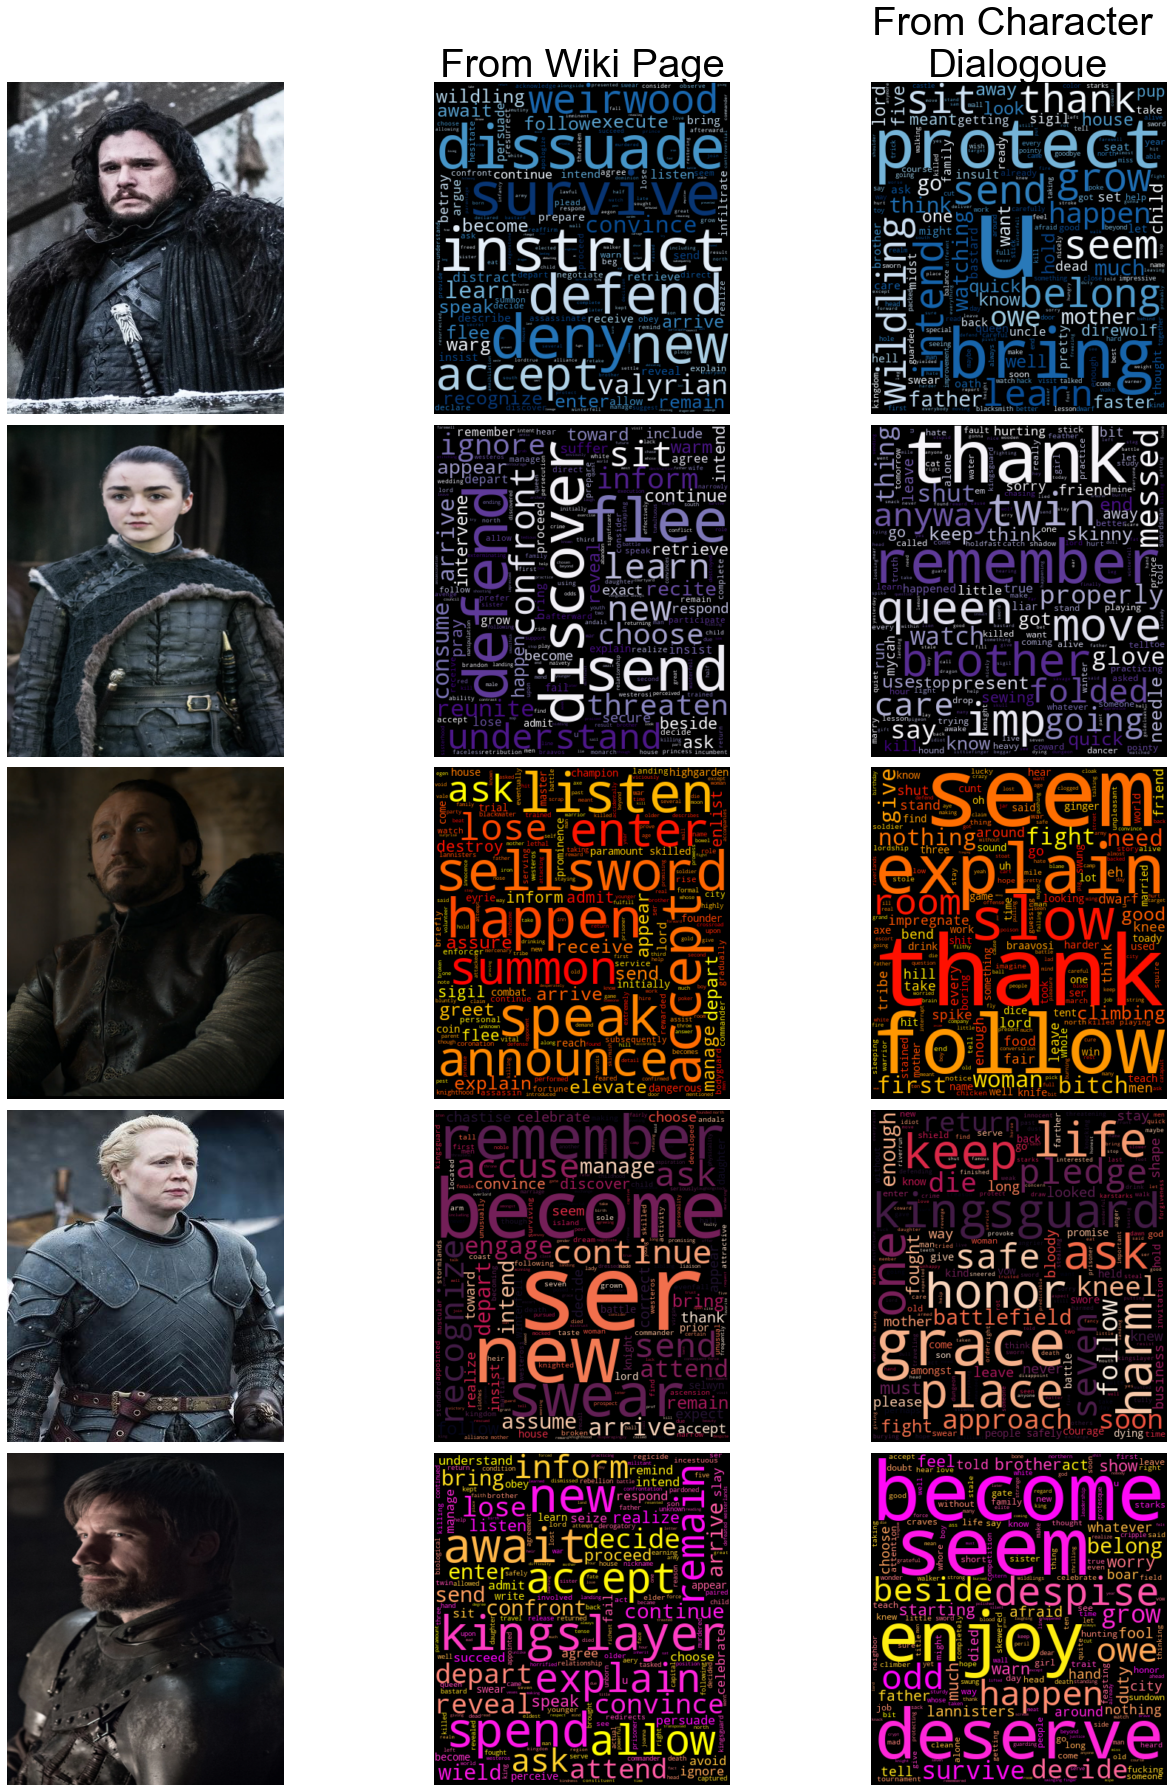

In [8]:
#hide_input
## Wordclouds based on character pages and compare with dialogoue


def getdata(url):
    r = requests.get(url)
    return r.text
def get_img(name):
    htmldata = getdata("https://gameofthrones.fandom.com/wiki/"+name)
    soup = BeautifulSoup(htmldata, 'html.parser')
    image = soup.find('img', attrs={"class":"pi-image-thumbnail"})
    return image['src']



def plot_wordcloud_characters(selected_char, tf_idf_char_pages, tf_idf_diag):

    plt.figure(figsize=(20,25))
    color_lst = ['Blues','Purples','autumn','rocket','spring_r']
    plot_idx = 1
    i = 0
    for char in selected_char:
        word_list = [] 
        for word, value in tf_idf_char_pages[char].items():
            word_list.append((word+' ')*int(np.ceil(value)))
        word_list = " ".join(word_list)
        wc_char_pages = WordCloud(collocations = False, background_color='black', 
                                    colormap=color_lst[i], width = 400, height = 450).generate(word_list)

        word_list = []
        for word, value in tf_idf_diag[char].items():
            word_list.append((word+' ')*int(np.ceil(value)))
        word_list = " ".join(word_list)
        wc_char_diag = WordCloud(collocations = False,background_color='black',
                                    colormap=color_lst[i], width = 400, height = 450).generate(word_list)


        plt.subplot(5,3,plot_idx)
        url = get_img(char)
        img = io.imread(url)
        plt.imshow(img, extent = [0,5,0,6], aspect = 1)
        plt.axis("off")
        plot_idx += 1

        plt.subplot(5,3,plot_idx)
        plt.imshow(wc_char_pages, interpolation='bilinear')#extent = [0,6,0,6], aspect = 1

        if plot_idx == 2:
            plt.title("From Wiki Page", fontsize = 40, color = 'black')
        plt.axis("off")

        plot_idx += 1
        plt.subplot(5,3,plot_idx)
        plt.imshow(wc_char_diag, interpolation='bilinear')#, extent = [0,6,0,6], aspect = 1
        
        if plot_idx == 3:
            plt.title("From Character \nDialogoue", fontsize = 40, color = 'black')
        plt.axis("off")
        plot_idx += 1
        i += 1

    plt.margins(x=0, y = 0)
    plt.tight_layout()
    plt.show()
    

selected_characters = ['Jon_Snow','Arya_Stark','Bronn','Brienne_of_Tarth','Jaime_Lannister']
plot_wordcloud_characters(selected_characters,tf_idf_char_page,tf_idf_char)



When comparing the generated wordclouds for the respective data sets it should be noted, that the same words are, for the most part, not present for the respective characters. This is expected as one would imagine that the text from the characters wikipedia pages are more descriptive of the character and their place in the story whereas the wordcloud from the dialogoue is exactly that; their most descrriptive words according to TF-IDC used throughout the series. This would be interesting to compare with sentiment analysis which is the second part of this page. 


In [9]:
#hide_input
def plot_wordcloud(races,tc_idf_race, name=None):
    plt.figure(figsize = (30,60))
    for i,race in enumerate(races):
        word_list= []
        for word, value in tc_idf_race[race].items():
            word_list.append((word+' ')*int(np.ceil(value)))
        word_list = " ".join(word_list)
        wc = WordCloud(collocations=False).generate(word_list)

        plt.subplot(9,3,i+1)
        plt.imshow(wc, interpolation='bilinear')
        if name is not None:
            race = name[i]
        plt.title(race, fontsize = 40)
        plt.axis("off")
    plt.tight_layout()
    plt.show()



In [10]:
#hide
# Wordclouds of allegiance

def plot_wordcloud_allegiance(selected_al, tf_idf_al):
    plt.figure(figsize=(24,28))

    color_lst = ['Blues','autumn','inferno','magma_r','Greys']
    i = 0
    plot_idx = 1
    for allegiance in selected_al:
        word_list = [] 
        for word, value in tf_idf_al[allegiance].items():
            word_list.append((word+' ')*int(np.ceil(value)))
        word_list = " ".join(word_list)
        wc_char_al = WordCloud(collocations = False, background_color='black',
                                colormap=color_lst[i]).generate(word_list)

        plt.subplot(6,2,plot_idx)
        url = get_img(allegiance.replace(" ","_"))
        img = io.imread(url)
        plt.imshow(img, extent = [0,5,0,6], aspect = 1)
        plt.axis("off")
        plt.title(allegiance, fontsize = 40)
        plot_idx += 1

        plt.subplot(6,2,plot_idx)
        plt.imshow(wc_char_al, interpolation='bilinear')#,extent = [0,6,0,6], aspect = 1)
        plt.axis("off")
        plot_idx += 1
        i += 1



    plt.tight_layout()
    plt.show()

<h3 align="center"> Wordclouds based on selected houses </h3>

Next, we will generate wordclouds based on the characters allegiance. This will be done by pooling the dialogoue text of characters belonging to the same allegiance together and, again, compute the respective TF-IDF score in order to generate the wordclouds. For this, we have selected the houses: Stark, Lannister, Targaryen, Greyjoy and the independent group The Night's Watch. It would be interesting to see, if the houses mottos would appear in these word clouds. The respective house mottos are:

<h5 align="center"> House Stark: Winter is coming <br>
House Lannister: Hear Me Roar! <br>
House Targaryen: Fire and Blood <br>
House Greyjoy: We Do Not Sow <br> <br>
</h5>

As the Night's Watch is not a House but rather a brotherhood sworn to protect The Wall, they do not have a motto.

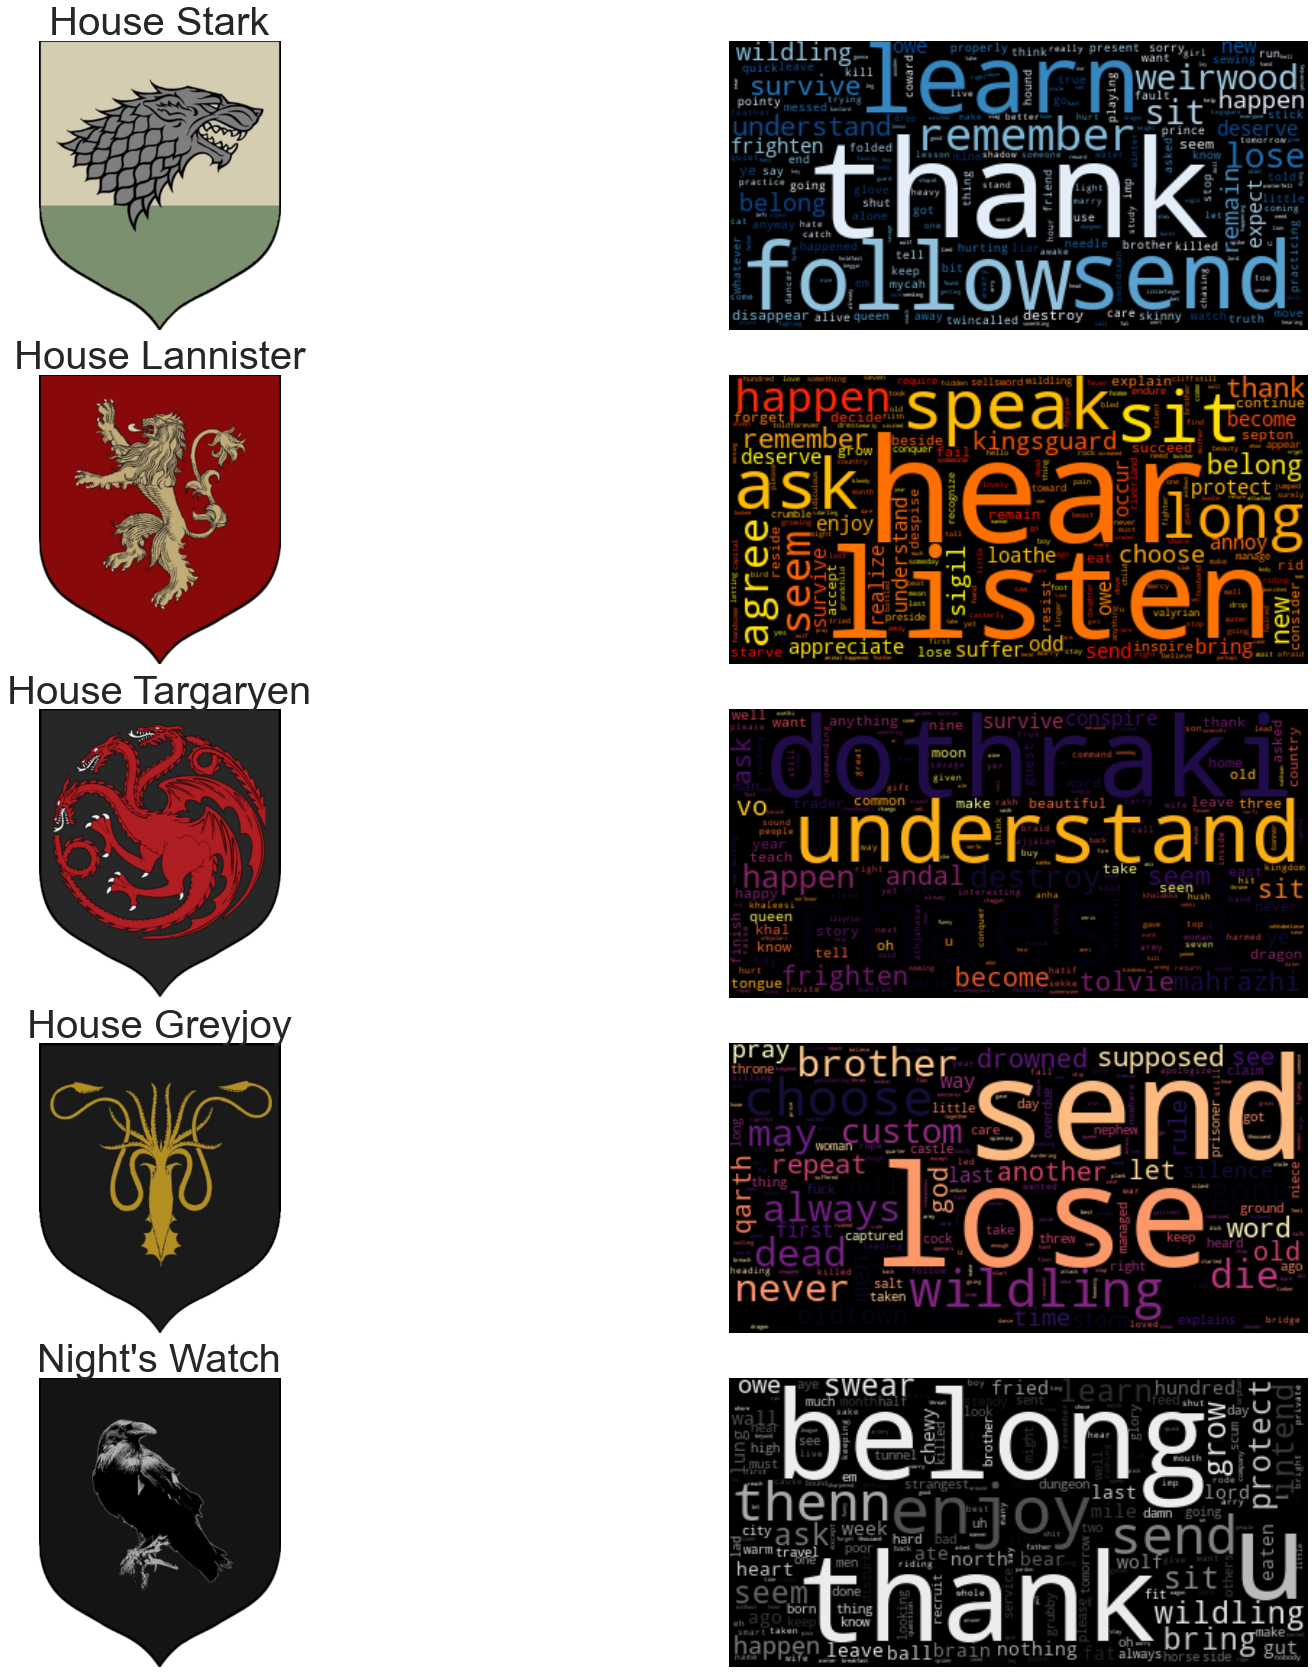

In [11]:
#hide_input
selected_al = ['House Stark','House Lannister','House Targaryen','House Greyjoy','Night\'s Watch']
plot_wordcloud_allegiance(selected_al, tf_idf_al)

When looking at the wordclouds above and the respective house mottos, only the Lannisters' *Hear* (big, middle) are present. All the wordclouds are, however, very descriptive of the respective houses. For instance for the Night's Watch, a military order sworn to protect The Wall, words like *protect*, *wildling* and *swear* are present. The same can be said for House Targaryan, where the main Targaryan character, Daenerys, is married to a dothraki warlord and later in the show, is a leader of dothraki people herself. 

In [12]:
#hide
def plot_wordcloud_season(seasons,tc_idf):
    plt.figure(figsize = (12,15))
    for i,season in enumerate(seasons):
        word_list= []
        for word, value in tc_idf[season].items():
            word_list.append((word+' ')*int(np.ceil(value)))
        word_list = " ".join(word_list)
        wc = WordCloud(collocations=False, background_color='black',
                        colormap='autumn_r').generate(word_list)

        plt.subplot(4,2,i+1)
        plt.imshow(wc, interpolation='bilinear')
        title = "Season {}".format(i+1)
        plt.title(title, fontsize = 40)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

<h3 align="center"> Wordclouds based on seasons </h3>

We will now generate wordclouds based on the wiki pages' season sections. It would be interesting to see how these wordclouds change as the story unfolds. It would also be intersting to investigate whether the overall theme of the series changes during the series course and if this can be seen in the wordclouds. 


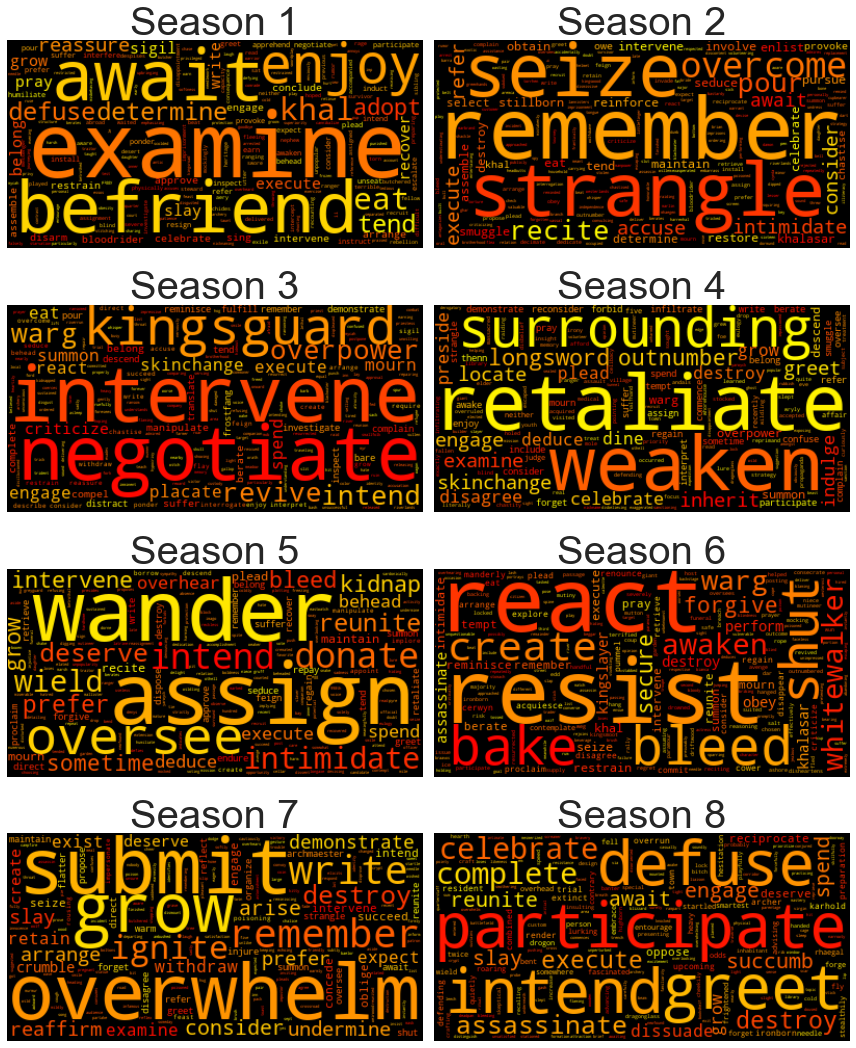

In [13]:
#hide_input
## Wordcloud based on season: 
char_season_wiki = {}
base_path = "../data/"+"got2/s"
for s in range(1,9):
    txt = []
    files = os.listdir(base_path + str(s)+"_cleaned/")
    for file in files:
        with open(base_path+str(s)+"_cleaned/"+ file, "r", encoding = "utf-8") as text_file:
                tmp = text_file.readlines()
        txt.extend(tmp)
    char_season_wiki["s"+str(s)] = clean_text(" ".join(txt), char_list)


tf_idf_season = tf_idf_func(char_season_wiki,['s'+str(i) for i in range(1,9)])
plot_wordcloud_season(["s"+ str(i) for i in range(1,9)], tf_idf_season)

Taking example in the wordclouds generated for season 1 & 8, the emphasized words seem very descriptive of their respective seasons. Starting with season 1:
- *execute, behead* : One of the main acts of season 1, is the execution of Lord Eddard Stark, the head of House Stark. He is, by the unexpected command of the king Joffrey Baratheon, beheaded in the middle of King's Landing.
- *Khal, bloodrider* : Another of the main story arcs, is the story of Daenarys Targaryan which takes place in a foreign land. In season 1, Daenarys is married of to a powerful Khal, Khal Drogo, in a trade by Daenarys brother. A Khal has three bloodriders who are to live and die by the life of their Khal. The words *Khal* and *bloodrider* being so prominent makes sense, as they are key roles in Daenarys' story arc.

Comparing the wordclouds of season 1 and season 8, it appears season 8 has different key words. For season 8:
- *celebrate* : The word *celebrate* stands in stark constrast to the prominent words *suffer* from season 1. This could be due to season 8 being the series final season and it's characters are therefore celebrating the story ending on a happy note (for some of the characters :wink: )
- *reunite* : The story culminates in the final season, many characters who have been seperated throughout the show are finally reunited in the final season of the show, hence emphasis on the word *reunite* makes sense. 

It should also be noted that the word *destroy* is present in the majority of the wordclouds, only being omitted in the wordclouds for season 1 and 3. 

<h1 align="center">  Sentiment of characters </h1>

In this second part of *text analysis*, we will do a sentiment analysis of the characters, again, based on both their wiki-pages and their dialogoue in the series. As we saw in the wordclouds of the selected characters, there was quite a difference in the wordclouds based on the respective wiki-pages and character dialogoue. It would be interesting to look at, if this also results in a different sentiment level of the character. Additionally, we will also do a sentiment analysis of the different seasons of the series. Perhaps it can be determined if any of the seasons were significantly different on a sentiment based level. 

For the sentiment analysis, we will apply both the dictionary based method of LabMT and the rule- and dictionary-based method of VADER. For further explanation of how these sentiment scores are computed and the difference between the two methods, we again refer to the [Explainer Notebook](https://mikkelmathiasen23.github.io/GameOfThrones_Network/Explainer_Notebook/).
It should be noted that the score of the two methods differ, as the LabMT score sentiment on a scale from \[1:9], while VADER scores on the range \[-4:4]. For LabMT, a score of 5 is considered neutral while a score within the range \[-0.05:0.05] is considered neutral for VADER.

In [14]:
#hide
base_path = "../data/"
LabMT = pd.read_table(base_path+'labMIT-1.0.txt', delimiter="\t")
#Convert LabMT to a dictionary:
LabMT_dict = {word : happiness_score for word,happiness_score in zip(LabMT['word'], LabMT['happiness_average']) }

#Load VADER wordlist:
analyzer = SentimentIntensityAnalyzer()

#Functions to compute LabMT and VADER sentiment values of tokens:
lemmatizer = WordNetLemmatizer() 
def sentiment_LabMT(tokens):
    #Extract tokens that are present in LabMT:
    tokens_LabMT = [token for token in tokens if token in LabMT_dict.keys()]
    #Extract sentiment values of tokens:
    happiness_LabMT = [LabMT_dict[token] for token in tokens_LabMT]

    #Return mean values of sentiments:
    return  np.mean(happiness_LabMT)

def sentiment_VADER(tokens):
    
    happiness_VADER = [analyzer.polarity_scores(sentence)['compound'] for sentence in tokens]
    return np.mean(happiness_VADER)

In [15]:
#hide
### GET DIAGLOGUE FOR EACH CHARACTER:
resp = requests.get("https://raw.githubusercontent.com/jeffreylancaster/game-of-thrones/master/data/script-bag-of-words.json")

diag = json.loads(resp.text)

char_diag = {}
for element in diag:
    episode = element['episodeNum']
    season = element['seasonNum']
    title = element['episodeTitle']
    text = element['text']
    for textObj in text:
        if textObj['name'] in char_diag:
            char_diag[textObj['name']].append(textObj['text'])
        else:
            char_diag[textObj['name']] = [textObj['text']]

tokens_LabMT = {char : clean_text(" ".join(text), characters) for char, text in char_diag.items()}
tokens_VADER = char_diag    

files = os.listdir(base_path+"got/")
char_list = [file.split('.txt')[0] for file in files]

#Suprress warnings:
warnings.filterwarnings("ignore")
#Compute sentiment for each character:
char_sentiment_LabMT = {char :sentiment_LabMT(tokens_values) for char, tokens_values in tokens_LabMT.items() if char.replace(" ", "_") in char_list}
char_sentiment_VADER = {char :sentiment_VADER(tokens_values) for char, tokens_values in tokens_VADER.items() if char.replace(" ", "_") in char_list}

#Sort and find the top 10 happiest and sadest:
happiest_VADER = sorted(char_sentiment_VADER, key = lambda i: char_sentiment_VADER[i],reverse = True)[:10]
happiest_LabMT = sorted(char_sentiment_LabMT, key = lambda i: char_sentiment_LabMT[i],reverse = True)[:10]

sadest_VADER = sorted(char_sentiment_VADER, key = lambda i: char_sentiment_VADER[i],reverse = False)[:10]
sadest_LabMT = sorted(char_sentiment_LabMT, key = lambda i: char_sentiment_LabMT[i],reverse = False)[:10]

print('Happiest based on VADER: ',happiest_VADER)
print('Happiest based on LabMT: ',happiest_LabMT)
print('Sadest based on VADER: ',sadest_VADER)
print('Sadest based on LabMT: ',sadest_LabMT)

Happiest based on VADER:  ['Dontos Hollard', 'Daisy', 'Pyat Pree', 'Harry Strickland', 'Olyvar', 'Mace Tyrell', 'Royal Steward', 'Margaery Tyrell', 'Matthos Seaworth', 'Marillion']
Happiest based on LabMT:  ['Alys Karstark', 'Daisy', 'Pyat Pree', 'Matthos Seaworth', 'Myrcella Baratheon', 'Lyanna Stark', 'Olyvar', 'Rhaegar Targaryen', 'Royal Steward', 'Trystane Martell']
Sadest based on VADER:  ['Anya Waynwood', 'Izembaro', 'Rorge', 'Hallyne', 'Rickard Karstark', 'Gregor Clegane', 'Leaf', 'Pypar', 'Syrio Forel', 'Obara Sand']
Sadest based on LabMT:  ['Gregor Clegane', 'Rakharo', 'Qotho', 'Pypar', 'Rickard Karstark', 'Grenn', 'Greatjon Umber', 'Sandor Clegane', 'Rast', 'Meryn Trant']


<h3 align="center"> Sentiment analysis of character dialogoue </h3>

In this subsection we are going to investigate the sentiment of characters based on their dialogoue which is based on transcripts. This is based on all dialogoue across all seasons as this is expected to give a better overview of each character sentiments. 

The figure below presents the sentiment of the 10 happiest and 10 sadest characters. To the left the sentiment are based on LabMT whereas the figure to the right is based on VADER. 

It should be noted that the two methods does not completely agree, but some characters are present in both results such as: *Daisy, Pyat Pree, Olyvar* and *Matthos Seaworth* are in top 10 of the happiest character in both results. Also some characters are present in both lists presenting the sadest characters such as *Gregor Clegane*. 

The happiest characters appear to be quite happy based on the VADER and LabMT score as the score only goes to 1 for VADER and 9 for LabMT and the same for saddest characters. 

In [16]:
#hide_input
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def plot_VADER_LabMT_scores(char_sentiment_VADER,char_sentiment_LabMT, title,error_bar = False,
  com_sentiment_VADER_sd=None, com_sentiment_LabMT_sd=None, x_text = "Characters" ):
    # Create figure with secondary y-axis
    fig = make_subplots(rows=1, cols=2)#,specs=[[{"secondary_y": True}]])
    # Add traces

    if error_bar:
        fig.add_trace(
            go.Bar(x=[*char_sentiment_LabMT],
            y=list(char_sentiment_LabMT.values()), 
            error_y=dict(
            type='data', # value of error bar given in data coordinates
            array= list(com_sentiment_LabMT_sd.values()),
            visible=True),name="LabMT score"),
            row=1, col=1,
            # secondary_y=False,
        )
        fig.add_trace(
            go.Bar(x=[*char_sentiment_VADER],
            y=list(char_sentiment_VADER.values()), 
            error_y=dict(
            type='data', # value of error bar given in data coordinates
            array= list(com_sentiment_VADER_sd.values()),
            visible=True),
            name="VADER score"),
            row=1, col=2,
            # secondary_y=True,
        )
        
    else:
        fig.add_trace(
            go.Bar(x=[*char_sentiment_LabMT],
            y=list(char_sentiment_LabMT.values()), name="LabMT score"),
            row=1, col=1,
        )

        fig.add_trace(
            go.Bar(x=[*char_sentiment_VADER],
            y=list(char_sentiment_VADER.values()), name="VADER score"),
            row=1, col=2,
        )

    # Add figure title
    fig.update_layout(
        title_text=title
    )

    # Set x-axis title
    fig.update_xaxes(title_text=x_text)
    # Set y-axes titles
    fig.update_yaxes(title_text="<b>LabMT sentiment score</b>", row=1,col = 1)
    fig.update_yaxes(title_text="<b>VADER sentiment score</b> ", row = 1, col = 2)
    return fig

sadest_VADER.reverse()
sadest_LabMT.reverse()
plot_dict_vader = {key: char_sentiment_VADER[key] for key in happiest_VADER+sadest_VADER}
plot_dict_LabMT = {key: char_sentiment_LabMT[key] for key in happiest_LabMT+sadest_LabMT}

fig = plot_VADER_LabMT_scores(plot_dict_vader, plot_dict_LabMT, title = "Sentiment analysis of character dialogoue")
fig.show()

<h3 align="center"> Sentiment analysis on character wiki pages </h3>

This subsection is going to investigate the sentiment of each character based on their character wiki page. We are further going to compare this with the sentiment of characters based on their dialogoue. 

In [17]:
#hide
char_pages = {}
characters = [f.split('.txt')[0] for f in os.listdir(base_path+"got_cleaned/")]

for char in characters:
    name = char.replace('_', ' ')
    with open(base_path+'got_cleaned/'+char+".txt", "r", encoding = "utf-8") as text_file:
            txt = text_file.readlines()
    char_pages[name] = txt

tokens_LabMT = {char : clean_text(" ".join(text), characters) for char, text in char_pages.items()}
tokens_VADER = char_pages

#Suprress warnings:
warnings.filterwarnings("ignore")
#Compute sentiment for each character:
char_sentiment_LabMT = {char :sentiment_LabMT(tokens_values) for char, tokens_values in tokens_LabMT.items() }
char_sentiment_VADER = {char :sentiment_VADER(tokens_values) for char, tokens_values in tokens_VADER.items() }

#Sort and find the top 10 happiest and sadest:
happiest_VADER = sorted(char_sentiment_VADER, key = lambda i: char_sentiment_VADER[i],reverse = True)[:10]
happiest_LabMT = sorted(char_sentiment_LabMT, key = lambda i: char_sentiment_LabMT[i],reverse = True)[:10]

sadest_VADER = sorted(char_sentiment_VADER, key = lambda i: char_sentiment_VADER[i],reverse = False)[:10]
sadest_LabMT = sorted(char_sentiment_LabMT, key = lambda i: char_sentiment_LabMT[i],reverse = False)[:10]

print('Happiest based on VADER: ',happiest_VADER)
print('Happiest based on LabMT: ',happiest_LabMT)
print('Sadest based on VADER: ',sadest_VADER)
print('Sadest based on LabMT: ',sadest_LabMT)

Happiest based on VADER:  ['Kraznys mo Nakloz', 'Xaro Xhoan Daxos', 'Leaf', 'Septa', 'Moro', 'Missandei', 'Anguy', 'Lyanna Stark', 'Renly Baratheon', 'Matthos Seaworth']
Happiest based on LabMT:  ['Septa', 'Order of Maesters', 'Moro', 'Matthos Seaworth', 'Leaf', 'Margaery Tyrell', 'Selyse Baratheon', 'Marillion', 'Tycho Nestoris', 'Ros']
Sadest based on VADER:  ['Amory Lorch', 'Orell', 'Karl Tanner', 'Polliver', 'Rast', 'Ramsay Bolton', 'Joffrey Baratheon', 'Alliser Thorne', 'Randyll Tarly', 'Obara Sand']
Sadest based on LabMT:  ['Biter', 'Amory Lorch', 'Rorge', 'Polliver', 'Lommy', 'Orell', 'Qhono', 'Rast', 'Black Lorren', 'Gregor Clegane']


From the figure below it can be seen that the two methods, again, do not completely agree on the result but both methods yield approximately the same result. Again the figure displays the 10 happiest and sadest characters based on LabMT and VADER.

At a first glance, it is noticed that the VADER score are lower for the happiest characters than in the previous part whereas the sadest achieve almost the same score. The LabMT results are quite similar in sentiment levels. 
Again many characters are found in both results such as *Septa, Moro, Orell* and *Polliver*. 

When comparing with the result based on the character dialogoue not many characters are found in all four results. This could indicate that the wiki-pages and dialogoue does not contain the same information, or that the chosen words on the wiki-pages do not necessarily imply information about the characters sentiment. 

It would be expected that the dialogoue contains greater variety of words that can explain the character mood, whereas the wiki-pages would contain words that describe the character and his/hers actions. We also notice that the variation in VADER sentiment scores are far greater when using the dialogoue compared with the wiki-page which could be an indication that our hypothesis are true. 

In [18]:
#hide_input
sadest_VADER.reverse()
sadest_LabMT.reverse()
plot_dict_vader = {key: char_sentiment_VADER[key] for key in happiest_VADER+sadest_VADER}
plot_dict_LabMT = {key: char_sentiment_LabMT[key] for key in happiest_LabMT+sadest_LabMT}
fig = plot_VADER_LabMT_scores(plot_dict_vader, plot_dict_LabMT, title ="Sentiment analysis of character wiki-page" )
fig.show()

<h3 align="center"> Sentiment analysis on the series' seasons </h3>

As a last element in our sentiment analysis we are going to dive into the sentiment of each season. This could help us investigate whether the general mode changes in each season and when combining this with the wordclouds of each season, indicate whether the theme of the series changes as it progressses. 


In [19]:
#hide
char_season_wiki = {}
base_path = "../data/"+"got2/s"
for s in range(1,9):
    txt = []
    files = os.listdir(base_path + str(s)+"_cleaned/")
    for file in files:
        with open(base_path+str(s)+"_cleaned/"+ file, "r", encoding = "utf-8") as text_file:
                tmp = text_file.readlines()
        txt.extend(tmp)
    char_season_wiki["s"+str(s)] = clean_text( " ".join(txt), characters)

In [20]:
#hide
tokens_LabMT = {char : text for char, text in char_season_wiki.items()}
tokens_VADER = char_season_wiki

#Suprress warnings:
warnings.filterwarnings("ignore")
#Compute sentiment for each character:
char_sentiment_LabMT = {char :sentiment_LabMT(tokens_values) for char, tokens_values in tokens_LabMT.items() }
char_sentiment_VADER = {char :sentiment_VADER(tokens_values) for char, tokens_values in tokens_VADER.items() }

#Sort and find the top 10 happiest and sadest:
happiest_VADER = sorted(char_sentiment_VADER, key = lambda i: char_sentiment_VADER[i],reverse = True)[:3]
happiest_LabMT = sorted(char_sentiment_LabMT, key = lambda i: char_sentiment_LabMT[i],reverse = True)[:3]

sadest_VADER = sorted(char_sentiment_VADER, key = lambda i: char_sentiment_VADER[i],reverse = False)[:3]
sadest_LabMT = sorted(char_sentiment_LabMT, key = lambda i: char_sentiment_LabMT[i],reverse = False)[:3]

print('Happiest based on VADER: ',happiest_VADER)
print('Happiest based on LabMT: ',happiest_LabMT)
print('Sadest based on VADER: ',sadest_VADER)
print('Sadest based on LabMT: ',sadest_LabMT)

Happiest based on VADER:  ['s6', 's1', 's7']
Happiest based on LabMT:  ['s1', 's6', 's3']
Sadest based on VADER:  ['s4', 's8', 's2']
Sadest based on LabMT:  ['s8', 's7', 's4']


The figure below shows the sentiment of each season based on LabMT and VADER methods. When looking at the LabMT it can be seen that all season are approximately neutral, whereas the VADER scores are just to the sad side of the spectrum. Further, it is noticed that season 4 are the sadest whereas season 6 are the "happiest" when comparing them. 

In season 4 a lot of the semi-main characters die such as Prince Oberyn, Joffrey Baratheon, Shay, Tywin Lannister and the Mountain (Gregor Clegane) are transformed into the Monster version of himself. Which could explain why this season is saddest according to the sentiment analysis. 

In [21]:
#hide_input
fig = plot_VADER_LabMT_scores(char_sentiment_VADER, char_sentiment_LabMT, title = "Sentiment analysis of seasons",x_text = 'Season')
fig.show()

<h1 align="center"> Dispersion plot </h1>

As a last element in our text analysis we are going to investigate some words and how they are used across different seasons, this could again help us understand how the theme of the series evolves. We are going to investigate the use of the selected words by the use of a lexical dispersion plot. 

In [22]:
#hide_input
from nltk.draw.dispersion import dispersion_plot
season_words = {}
wnlet = WordNetLemmatizer()

for s in range(1,9):
    season_words[s] = []
    for obj in diag:
        if obj['seasonNum'] == s:
            words = [sentence['text'] for sentence in obj['text']]
            word_tokens = wordpunct_tokenize(" ".join(words))    
            filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
            filtered_sentence = [w for w in filtered_sentence if w != "..."]
            words = [wnlet.lemmatize(w.lower()) for w in filtered_sentence]
            season_words[s].extend(words)

In [23]:
#hide
from matplotlib import pylab

def dispersion_plot(text, words, xticks = None, xlabels = None, lines = None):
    '''
    We have modified the dispersion plot function by NLTK to include custom x-ticks, so we can display how
    the use of selected words changes through the series.
    Further we have changed the default lines created by sns.set(), to better display when one season stops and another starts.
    '''
    text = list(text)
    words.reverse()

    points = [
        (x, y)
        for x in range(len(text))
        for y in range(len(words))
        if text[x] == words[y]
    ]
    if points:
        x, y = list(zip(*points))
    else:
        x = y = ()

    # Make plot
    if lines is not None: 
        for l in lines:
            pylab.plot([l,l], [-1,len(words)], color = 'white')
    pylab.plot(x, y, "b|", scalex=0.1, markersize = 12)
    pylab.yticks(list(range(len(words))), words, color="b", fontsize = 12)
    pylab.ylim(-1, len(words))
    pylab.title("Lexical Dispersion Plot", fontsize = 20)
    pylab.xlabel("Season offset", fontsize = 12)
    if xticks is not None:
        pylab.xticks(ticks=xticks, labels=xlabels, rotation = '45', fontsize = 12)
    plt.tight_layout()
    plt.grid(axis = 'x')
    pylab.show()

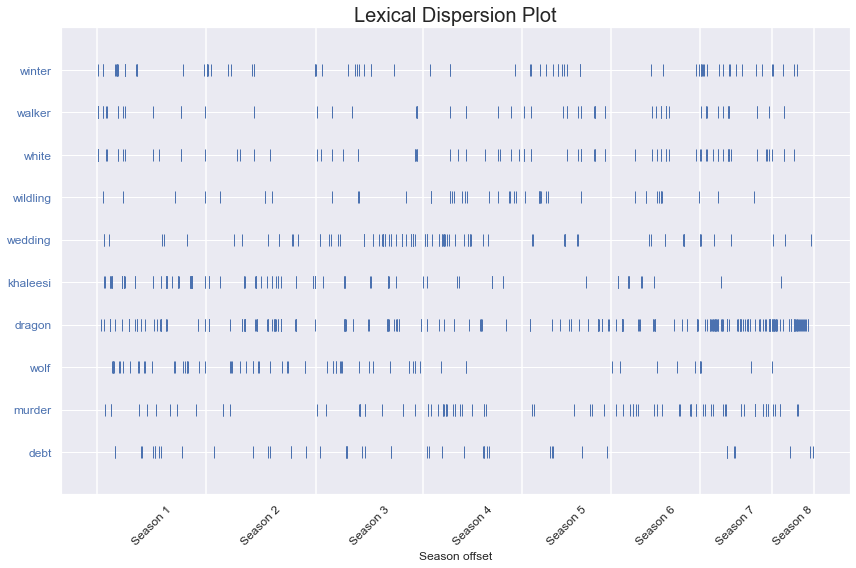

In [24]:
#hide_input
all_words = []
for words in season_words.values():
    all_words.extend(words)

ticks = []
labels = []
vert_line = [0]
tmp = 0
for i, (key, value) in enumerate(season_words.items()):
    ticks.append(int(np.round((tmp +  (tmp+len(value)))/2)))
    labels.append('Season ' + str(key))
    tmp += len(value)
    vert_line.append(tmp)

plt.figure(figsize = (12,8))
dispersion_plot(all_words, ["winter","walker","white","wildling",'wedding','khaleesi', "dragon","wolf", "murder","debt"],
                    xticks = ticks, xlabels = labels, lines = vert_line)


Looking at the lexical dispersion plot above, the first word we chose was *winter*. This is due to the famous Stark house words being "Winter is coming" and we wanted to investigate how much this phrase was actually used. It appears *winter* is most used in the beginning and the end of the show. Only sorting for the word *winter* has the caveat though, that other common phrases such as *the long winter* are also represented here.

Another interesting comparison is the words *dragon* and *wolf*. Both the Targaryens and Starks are refered to as dragons and wolves respectivly but the Stark children also raise their own dire wolf throughout the show. The same can be said for Daenarys whose dragons are born in the end of season 1 and raised througout the show. In the beginning of the show, the wolves are more commonly mentioned compared to the ending where they are barely mentioned. The opposite holds true for *dragon* which is less mentioned in the beginning but mentioned more and more as the story unfolds. 

It can also be seen that the word *wedding* is mentioned most during season 3 and season 4. This holds true to the story as both Robb Stark, Joffrey Baratheon and Sansa Stark are all married during these seasons. 

<h1 align = "center"> Subconclusion </h1>

During this section, we have found the most important words on a character, allegiance and seasonal level. The found words and their importance were represented with wordclouds and it was found that the chosen words represented the character, allegiance and season well. A comparison of the different data sources of wiki pages and show dialogoue has also been made, where it was found that the choice of words in these data sources are significantly different. This also makes sense, as it would be expected that the wikipedia page is more descriptive of the story,its  characters and the setting whereas the dialogue would be expected to be a more crude choice of words.

Using sentiment analysis, the happiest and saddest characters of the show were found. Both according to the characters dialogoue but also their wikipedia pages. It was also found that the sentiment of wikipedia pages are different than the sentiment of the dialogoues.

Finally, a lexical dispersion plot was computed in order to visualise how some of the common words of the Game of Thrones world were used throughout the show. 